In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from numba import float32, float64, jit, NumbaPerformanceWarning
import warnings
import os
from control.matlab import *
warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

from utils import simulate_onestep_campi_example_1

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [2]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_onestep import GPTConfig, GPT
from dataset_simple_example_1 import SimpleExample1Dataset
import tqdm
import argparse
import metrics

In [3]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [4]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [5]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 50 # 256

# Compute settings
cuda_device = "cuda:1"
no_cuda = True
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [6]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_controller_simple_example_1.pt", map_location=device)

In [7]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

In [8]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict);

number of parameters: 2.43M


In [9]:
test_ds = SimpleExample1Dataset(seq_len=seq_len, normalize=True, return_y=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [10]:
# Prediction
batch_u, batch_e, batch_y= next(iter(test_dl))
with torch.no_grad():
    batch_u_pred, loss = model(batch_e, batch_u)

/home/rbusetto/.virtualenvs/sysid-transformers-control/lib/python3.10/site-packages/control/timeresp.py:1003: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


In [11]:
import pickle as pkl

with open('../data/control/test_set_simple_example_1.pkl', 'rb') as f:
    test_set = pkl.load(f)

data_test = test_set['data_test']

In [12]:
print(batch_y.shape)

torch.Size([50, 500, 1])


In [13]:
print(batch_y[1,:,-1].shape)

torch.Size([500])


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

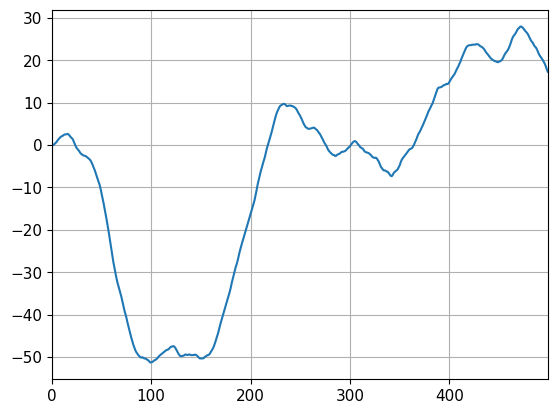

In [14]:
# reference
Ts = 1e-2
t_CL = np.arange(0, 5, Ts)
s = tf('s')
tau = 0.05  # s
M = 1 / (1 + (tau / (2 * np.pi)) * s)
M = M * (1 + 1e-2 * (tau / (2 * np.pi)) * s)  # add a high freq zero for inversion
# get virtual error
r = lsim(M ** (-1), batch_y[1,:,-1], t_CL)[0]
plt.plot(r)

In [15]:
n_testing = 1
H = 10

y_log = np.zeros((n_testing,len(t_CL)))
e_log = np.zeros((n_testing,len(t_CL)))
u_log = np.zeros((n_testing,len(t_CL)))

Ts = 1e-2; Fs = 1 / Ts
s = tf('s')
# problem data

with torch.no_grad():
    for n_testing in range(1):#len(data_test)):
        
        print(n_testing)
        data = data_test[n_testing]
        
        # system
        num = [data['num_1']]
        den = [data['den_1'], data['den_2'], data['den_3']]
        P = tf(num, den)
        
        
        e = torch.Tensor([[[]]])
        u = torch.Tensor([[[]]])
        
        # This is like t=0, for our model we need u(-1).
        u_i = 1e-6 # u(-1)
        x_i = np.array([[1e-6, 1e-6]])
        y_i = 1e-6
        
        u_log[n_testing,0] = u_i
        y_log[n_testing,0] = y_i
        
        for i in range(0,len(t_CL)):#batch_u.shape[0]): # for each system
            
            u_i = torch.Tensor([[[u_i]]])   # first you add u(t)
            u = torch.cat((u,u_i / 1000),2)
            
            e_i = torch.Tensor([[[r[i] - y_i]]]) # e(t)
            e = torch.cat((e,e_i / 0.3),2)
            
            if i < H:
                pred, _ = model(e.reshape(1,-1,1), u.reshape(1,-1,1))
            else:
                e_tmp = e.reshape(1,-1,1)
                u_tmp = u.reshape(1,-1,1)
                pred, _ = model(e_tmp[:,-H:,:], u_tmp[:,-H:,:])
            
            u_i = pred[:,-1,:].item() * 1000 # u(t)
            
            # Controller u(t) = C(e(t-1),u(t-1))
            
            y_i, _, x_i = lsim(P, u_i, np.array([0.0, Ts]), x_i[-1])
            y_i = y_i[-1]  # y(t) <- y(t+1)
            
        
            e_log[n_testing,i] = e_i
            
            if (i+1) < len(t_CL) :
              u_log[n_testing,i+1] = u_i
              y_log[n_testing,i+1] = y_i

0


/home/rbusetto/.virtualenvs/sysid-transformers-control/lib/python3.10/site-packages/control/timeresp.py:1009: UserWarning: Non-zero initial condition given for transfer function system. Internal conversion to state space used; may not be consistent with given X0.
  warnings.warn(


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


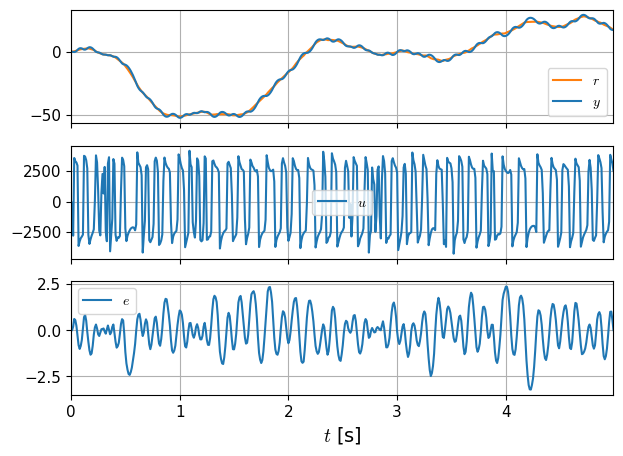

In [16]:
fig = plt.figure(figsize=(7, 5))
ax1 = plt.subplot(311)
#plt.plot(t_CL, r)
plt.plot(t_CL, r, label="$r$", c='tab:orange')
plt.plot(t_CL, y_log.T, label="$y$", c='tab:blue', alpha=1)
plt.legend(['$r$','$y$'])
plt.tick_params('x', labelbottom=False)

ax2 = plt.subplot(312, sharex=ax1)
plt.plot(t_CL, u_log.T, c='tab:blue', alpha=1)
plt.legend(['$u$'])
plt.tick_params('x', labelbottom=False)

ax3 = plt.subplot(313, sharex=ax1)
plt.plot(t_CL, e_log.T, c='tab:blue', alpha=1)
plt.xlabel('$t$ [s]')
plt.legend(['$e$'])

# plt.savefig('transformer_controller.pdf')

plt.show()